In [1]:
# ! pip install geopandas

# **Librairies**

In [2]:
import pandas as pd
import numpy as np

import gzip
from google.colab import drive
import os

import matplotlib.pyplot as plt
import altair as alt
import folium
import seaborn as sb

from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults, VARResultsWrapper

# Suppress warnings
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter("ignore", ValueWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Mount Drive and Upload Data Files**

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('drive/Shareddrives/CapstoneProject/AoT_Chicago Reduced Data_V3')

**raw data**

In [6]:
!zcat others/data.csv.gz | head -20

timestamp,node_id,subsystem,sensor,parameter,value_raw,value_hrf
2018/01/01 00:00:06,001e0610e532,chemsense,at0,temperature,-1106,-11.06
2018/01/01 00:00:06,001e0610e532,chemsense,at1,temperature,-1077,-10.77
2018/01/01 00:00:06,001e0610e532,chemsense,at2,temperature,-1009,-10.09
2018/01/01 00:00:06,001e0610e532,chemsense,at3,temperature,-972,-9.72
2018/01/01 00:00:06,001e0610e532,chemsense,chemsense,id,NA,541eec3ebfa6
2018/01/01 00:00:06,001e0610e532,chemsense,co,concentration,2068,NA
2018/01/01 00:00:06,001e0610e532,chemsense,h2s,concentration,-345,NA
2018/01/01 00:00:06,001e0610e532,chemsense,lps25h,pressure,101939,1019.39
2018/01/01 00:00:06,001e0610e532,chemsense,lps25h,temperature,-954,-9.54
2018/01/01 00:00:06,001e0610e532,chemsense,no2,concentration,649,NA
2018/01/01 00:00:06,001e0610e532,chemsense,o3,concentration,3305,NA
2018/01/01 00:00:06,001e0610e532,chemsense,oxidizing_gases,concentration,4057,NA
2018/01/01 00:00:06,001e0610e532,chemsense,reducing_gases,concentration,4498

**reduced dataset**

In [7]:
files = [os.getcwd() + '/' + f for f in os.listdir()]
files

['/content/drive/Shareddrives/CapstoneProject/AoT_Chicago Reduced Data_V3/others',
 '/content/drive/Shareddrives/CapstoneProject/AoT_Chicago Reduced Data_V3/Numeric_001e0610ef26.csv',
 '/content/drive/Shareddrives/CapstoneProject/AoT_Chicago Reduced Data_V3/Numeric_001e0610890f.csv',
 '/content/drive/Shareddrives/CapstoneProject/AoT_Chicago Reduced Data_V3/Numeric_001e061144c0.csv',
 '/content/drive/Shareddrives/CapstoneProject/AoT_Chicago Reduced Data_V3/Numeric_001e06109401.csv',
 '/content/drive/Shareddrives/CapstoneProject/AoT_Chicago Reduced Data_V3/Numeric_001e061144cd.csv',
 '/content/drive/Shareddrives/CapstoneProject/AoT_Chicago Reduced Data_V3/Numeric_001e061144d6.csv',
 '/content/drive/Shareddrives/CapstoneProject/AoT_Chicago Reduced Data_V3/Numeric_001e0610ef27.csv',
 '/content/drive/Shareddrives/CapstoneProject/AoT_Chicago Reduced Data_V3/Numeric_001e0610ef29.csv',
 '/content/drive/Shareddrives/CapstoneProject/AoT_Chicago Reduced Data_V3/Numeric_001e0610ef68.csv',
 '/conte

# **Rebuild Datasets**

Example of one node data...

In [8]:
sample_data = pd.read_csv('Numeric_001e06112e77.csv')
sample_data

,timestamp,subsystem,sensor,parameters,value_raw,value_hrf,valid_raw_measurements_count,valid_hrf_measurements_count
0,2/27/2018 11:30:00 AM,chemsense,at0,temperature,670.7368,6.707371,114,114
1,2/27/2018 11:30:00 AM,chemsense,at1,temperature,700.0702,7.000701,114,114
2,2/27/2018 11:30:00 AM,chemsense,at2,temperature,756.7544,7.567541,114,114
3,2/27/2018 11:30:00 AM,chemsense,at3,temperature,815.0351,8.150351,114,114
4,2/27/2018 11:30:00 AM,chemsense,lps25h,temperature,940.0088,9.400089,114,114
...,...,...,...,...,...,...,...,...
321640,2/27/2020 6:30:00 PM,metsense,mma8452q,acceleration_x,65535.0000,-0.977000,35,35
321641,2/27/2020 6:30:00 PM,metsense,mma8452q,acceleration_y,65535.0000,-0.977000,35,35
321642,2/27/2020 6:30:00 PM,metsense,mma8452q,acceleration_z,65535.0000,-0.977000,35,35
321643,2/27/2020 6:30:00 PM,metsense,spv1840lr5h_b,intensity,NaN,56.081127,0,35


**master dataframe**

In [12]:
def get_data_clustering():
  '''Combine the data into a wide dataframe grouped by the time and the parameters to value hrf.  Missing values for hrf are replaced by value_raw'''
  df= pd.DataFrame()
  files = os.listdir()
  for i in files:
    if 'node' in i:
      continue
    if 'others' in i:
      continue
    if 'WaggleData' in i:
      continue
    if 'app.py' in i:
      continue
    if '.ipynb_checkpoints' in i:
      continue
    if 'streamlit' in i:
      continue

    filepath = os.getcwd() + '/'+i
    name = i.strip('Numeric_').strip('.csv')
    data = pd.read_csv(filepath, usecols=['timestamp', 'subsystem','sensor', 'parameters', 'value_hrf']).rename(columns={'value_hrf':'values'})

    data['values'] = pd.to_numeric(data['values'], errors='coerce')
    data = data[(data['timestamp'] != 'timestamp') & (data.parameters != 'id')]
    data['node_id'] = name
    data['date'] = pd.to_datetime(data['timestamp']).dt.date

    data = data.groupby(['node_id', 'subsystem', 'sensor', 'date', 'parameters']).mean()['values'].reset_index()
    df = df.append(data)
    
  return df

In [13]:
# master_df = get_data_clustering()
# master_df

,node_id,subsystem,sensor,date,parameters,values
0,001e0610ef26,lightsense,apds_9006_020,2018-03-13,intensity,12.849059
1,001e0610ef26,lightsense,hih6130,2018-03-13,humidity,27.483533
2,001e0610ef26,lightsense,hih6130,2018-03-13,temperature,15.136831
3,001e0610ef26,lightsense,hih6130,2018-03-17,humidity,84.650000
4,001e0610ef26,lightsense,hih6130,2018-03-17,temperature,-8.195000
...,...,...,...,...,...,...
12740,001e061144be,metsense,tsys01,2019-11-30,temperature,6.790867
12741,001e061144be,metsense,tsys01,2019-12-01,temperature,8.229780
12742,001e061144be,metsense,tsys01,2019-12-02,temperature,4.955356
12743,001e061144be,metsense,tsys01,2019-12-03,temperature,3.386816


In [14]:
# master_df.to_csv('others/cleaned_dataset.csv', index=False)

In [9]:
master_df = pd.read_csv('others/cleaned_dataset.zip').tail()
master_df

,node_id,subsystem,sensor,date,parameters,values
1238499,001e061144be,metsense,tsys01,2019-11-30,temperature,6.790867
1238500,001e061144be,metsense,tsys01,2019-12-01,temperature,8.229780
1238501,001e061144be,metsense,tsys01,2019-12-02,temperature,4.955356
1238502,001e061144be,metsense,tsys01,2019-12-03,temperature,3.386816
1238503,001e061144be,metsense,tsys01,2019-12-04,temperature,6.708525


**nodes description**

In [18]:
nodes = pd.read_csv('others/nodes.csv')
nodes

,node_id,project_id,vsn,address,lat,lon,description,start_timestamp,end_timestamp
0,001e0610ba46,AoT_Chicago,004,State St & Jackson Blvd Chicago IL,41.878377,-87.627678,AoT Chicago (S) [C],2017/10/09 00:00:00,NaN
1,001e0610ba3b,AoT_Chicago,006,18th St & Lake Shore Dr Chicago IL,41.858136,-87.616055,AoT Chicago (S),2017/08/08 00:00:00,NaN
2,001e0610f02f,AoT_Chicago,00A,Lake Shore Drive & Fullerton Ave Chicago IL,41.926261,-87.630758,AoT Chicago (S) [CA],2018/05/07 00:00:00,NaN
3,001e0610ba8f,AoT_Chicago,00D,Cornell & 47th St Chicago IL,41.810342,-87.590228,AoT Chicago (S),2017/08/08 00:00:00,NaN
4,001e0610ba16,AoT_Chicago,010,Homan Ave & Roosevelt Rd Chicago IL,41.866349,-87.710543,AoT Chicago (S) [C],2018/07/18 00:00:00,NaN
...,...,...,...,...,...,...,...,...,...
121,001e06118433,AoT_Chicago,10E,ComEd Training Center,41.829806,-87.659467,AoT Chicago (S) [CP] {ComEd},2019/04/25 00:00:00,NaN
122,001e061183bf,AoT_Chicago,11A,ComEd Training Center,41.829806,-87.659467,AoT Chicago (S) [CP] {ComEd},2019/04/25 00:00:00,NaN
123,001e0611804d,AoT_Chicago,11E,ComEd Training Center,41.829806,-87.659467,AoT Chicago (S) [CP] {ComEd},2019/04/25 00:00:00,NaN
124,001e061182a2,AoT_Chicago,13B,ComEd Training Center,41.829806,-87.659467,AoT Chicago (S) [CP] {ComEd},2019/04/25 00:00:00,NaN


**sensors**

In [20]:
sensors = pd.read_csv('others/sensors.csv')
sensors

,ontology,subsystem,sensor,parameter,hrf_unit,hrf_minval,hrf_maxval,datasheet
0,/sensing/air_quality/gases/co,chemsense,co,concentration,ppm,0.0,1000.0,https://github.com/waggle-sensor/sensors/raw/m...
1,/sensing/air_quality/gases/h2s,chemsense,h2s,concentration,ppm,0.0,50.0,https://github.com/waggle-sensor/sensors/raw/m...
2,/sensing/air_quality/gases/no2,chemsense,no2,concentration,ppm,0.0,20.0,https://github.com/waggle-sensor/sensors/raw/m...
3,/sensing/air_quality/gases/o3,chemsense,o3,concentration,ppm,0.0,20.0,https://github.com/waggle-sensor/sensors/raw/m...
4,/sensing/air_quality/gases/oxidizing_gases,chemsense,oxidizing_gases,concentration,ppm,0.0,100.0,https://github.com/waggle-sensor/sensors/blob/...
...,...,...,...,...,...,...,...,...
188,/system/wagman_device_temperature,wagman,wagman_th,4,temperature,NaN,NaN,https://github.com/waggle-sensor/plugin_manage...
189,/system/wagman_communication,wagman,wagman_comm,up,bool,0.0,1.0,https://github.com/waggle-sensor/plugin_manage...
190,/system/wagman_uptime,wagman,wagman_uptime,uptime,s,0.0,NaN,https://github.com/waggle-sensor/plugin_manage...
191,/vision/counters,image,image_detector,person_total,counts,0.0,NaN,https://github.com/waggle-sensor/plugin_manage...


# **Data Exploration** 

**node locations**

In [21]:
latlon = list(zip(nodes['lat'], nodes['lon'], nodes['node_id']))
mapit = folium.Map( location=[41.85, -87.65], zoom_start=11 )

for coord in latlon:

  folium.Marker( location=[ coord[0], coord[1] ],
                tooltip=('node:', coord[2], 'lat:', coord[0], 'lon:', coord[1]),
                #  tooltip = ''
                popup=coord[2]).add_to( mapit )

folium.TileLayer('cartodbpositron').add_to(mapit)
mapit

**time for data collection**

In [23]:
up_df = pd.DataFrame(columns=['node_id', 'start', 'end'])

idx = 0
for node in nodes.node_id:
  sample = master_df[master_df.node_id == node]
  up_df.loc[idx] = [node, pd.to_datetime(sample.date).min(), pd.to_datetime(sample.date).max()]
  idx += 1

up_df['days_up'] = (up_df.end.dt.date - up_df.start.dt.date).dt.days
up_df

,node_id,start,end,days_up
0,001e0610ba46,2018-01-17,2020-05-22,856.0
1,001e0610ba3b,2017-12-31,2018-04-29,119.0
2,001e0610f02f,2018-05-08,2019-08-03,452.0
3,001e0610ba8f,2018-03-12,2019-06-20,465.0
4,001e0610ba16,2018-07-18,2019-05-30,316.0
...,...,...,...,...
121,001e06118433,2019-12-14,2020-04-23,131.0
122,001e061183bf,2019-12-14,2021-01-31,414.0
123,001e0611804d,2019-12-14,2021-03-21,463.0
124,001e061182a2,2019-12-14,2020-05-18,156.0


In [24]:
up_df.describe().T

,count,mean,std,min,25%,50%,75%,max
days_up,114.0,416.315789,265.247966,0.0,222.5,399.0,574.75,1112.0


In [25]:
base = alt.Chart(up_df).encode(
    alt.X('node_id:N')
).properties(width = 1500)

rule = base.mark_rule().encode(
    alt.Y('start:T', axis = alt.Axis(format='%m/%y', title='Date')), #,labelAngle=-45
    alt.Y2('end:T')
)

startpoints = base.mark_circle(size=60).encode(
    alt.Y('start:T'),
    # alt.Y2('end:T')
)

endpoints = base.mark_circle(size=60).encode(
    # alt.Y('start:T'),
    alt.Y('end:T'), color = alt.value("#FFAA00")
)

rule + startpoints + endpoints

alt.LayerChart(...)

**node sensor types**

In [26]:
subsystem_types = master_df[['node_id', 'subsystem']].groupby(['node_id', 'subsystem']).count().reset_index()
subsystem_types['count'] = 1

In [27]:
alt.Chart(subsystem_types).mark_tick().encode(
    x='node_id',
    y='subsystem',
    color='subsystem'
).properties(width=1400) #, height=250

alt.Chart(...)

**sensors**

In [34]:
subsystem_sensor_types = master_df[['subsystem', 'sensor']].groupby(['subsystem', 'sensor']).count().reset_index()
subsystem_types['count'] = 1

In [35]:
alt.Chart(subsystem_sensor_types).mark_rect().encode(
    x='sensor',
    y='subsystem',
    # color='subsystem'
).properties(width=1400) #, height=250

alt.Chart(...)

In [36]:
filtered_subsystems = master_df[master_df['subsystem'].isin(['lightsense', 'metsense', 'chemsense', 'alphasense', 'plantower'])]
subsystem_sensor_types = filtered_subsystems[['subsystem', 'sensor']].groupby(['subsystem', 'sensor']).count().reset_index()
subsystem_types['count'] = 1

In [37]:
alt.Chart(subsystem_sensor_types).mark_rect().encode(
    x='sensor',
    y='subsystem',
    color='subsystem'
).properties(width=1400) #, height=250

alt.Chart(...)

In [38]:
filtered_subsystems['parameters'].unique()

array(['intensity', 'humidity', 'temperature', 'concentration',
       'pressure', 'ir_intensity', 'uv_intensity',
       'visible_light_intensity', 'magnetic_field_x', 'magnetic_field_y',
       'magnetic_field_z', 'acceleration_x', 'acceleration_y',
       'acceleration_z', 'pm1', 'pm10', 'pm2_5', 'sample_flow_rate',
       'sampling_period', 'fw', '10um_particle', '1um_particle',
       '2_5um_particle', '5um_particle', 'pm10_atm', 'pm10_cf1',
       'pm1_atm', 'pm1_cf1', 'pm25_atm', 'pm25_cf1', 'point_3um_particle',
       'point_5um_particle', 'onset_rain', 'soil_conductivity',
       'soil_dielectric', 'soil_temperature'], dtype=object)

In [39]:
sensor_types_parameters = filtered_subsystems[['subsystem', 'sensor', 'parameters']].groupby(['subsystem', 'sensor', 'parameters']).count().reset_index()
sensor_types_parameters['count'] = 1
sensor_types_parameters

,subsystem,sensor,parameters,count
0,alphasense,opc_n2,fw,1
1,alphasense,opc_n2,pm1,1
2,alphasense,opc_n2,pm10,1
3,alphasense,opc_n2,pm2_5,1
4,alphasense,opc_n2,sample_flow_rate,1
...,...,...,...,...
59,plantower,pms7003,pm1_cf1,1
60,plantower,pms7003,pm25_atm,1
61,plantower,pms7003,pm25_cf1,1
62,plantower,pms7003,point_3um_particle,1


In [40]:
alt.Chart(sensor_types_parameters).mark_rect().encode(
    x='parameters',
    y='sensor',
    color='subsystem'
).properties(width=1000, height=500)#.configure_axis(grid=True)

alt.Chart(...)

In [41]:
filtered_subsystems

,node_id,subsystem,sensor,date,parameters,values
0,001e0610ef26,lightsense,apds_9006_020,2018-03-13,intensity,12.849059
1,001e0610ef26,lightsense,hih6130,2018-03-13,humidity,27.483533
2,001e0610ef26,lightsense,hih6130,2018-03-13,temperature,15.136831
3,001e0610ef26,lightsense,hih6130,2018-03-17,humidity,84.650000
4,001e0610ef26,lightsense,hih6130,2018-03-17,temperature,-8.195000
...,...,...,...,...,...,...
12740,001e061144be,metsense,tsys01,2019-11-30,temperature,6.790867
12741,001e061144be,metsense,tsys01,2019-12-01,temperature,8.229780
12742,001e061144be,metsense,tsys01,2019-12-02,temperature,4.955356
12743,001e061144be,metsense,tsys01,2019-12-03,temperature,3.386816


In [42]:
pms = ['10um_particle', '1um_particle', '2_5um_particle', '5um_particle', 'pm1', 'pm10', 'pm10_atm', 'pm10_cf1', 'pm1_atm', 'pm1_cf1', 'pm25_atm', 'pm25_cf1', 'pm2_5', 'point_3um_particle', 'point_5um_particle', 'fw', 'sample_flow_rate', 'sampling_period']
# 'concentration', 
df_w_pms = filtered_subsystems[filtered_subsystems['parameters'].isin(pms) ].drop(['node_id', 'subsystem', 'sensor'], axis=1)

df_w_pms = pd.pivot_table(df_w_pms, values = 'values', index = 'date', columns = 'parameters', aggfunc=np.mean).reset_index()
# df_w_pms = df_w_pms.fillna(method="bfill")

# df_w_pms
df_w_pms.describe()

parameters,10um_particle,1um_particle,2_5um_particle,5um_particle,fw,pm1,pm10,pm10_atm,pm10_cf1,pm1_atm,pm1_cf1,pm25_atm,pm25_cf1,pm2_5,point_3um_particle,point_5um_particle,sample_flow_rate,sampling_period
count,679.000000,679.000000,679.000000,679.000000,541.000000,1048.000000,1048.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,1048.000000,679.000000,679.000000,1.048000e+03,1048.000000
mean,489.678659,520.060323,517.448629,503.109386,13.711254,0.746852,1.715372,483.293399,330.786945,307.940682,355.838772,515.455607,400.429466,0.895331,922.440473,503.109386,-5.968326e+31,68.563699
std,3845.413960,4046.140008,4158.068691,4001.236442,15.846225,2.576851,19.051030,3912.589056,2830.887455,2342.955775,2808.417202,4180.990298,3471.076799,3.628771,3874.003687,4001.236442,1.932116e+33,130.366867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.254805e+34,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.049999,0.090791,0.124759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.104461,0.000000,0.000000,5.780254e-01,25.102154
50%,0.216743,0.318260,0.268531,0.240845,12.099992,0.244946,0.344340,0.266667,0.018519,1.289114,0.001166,0.696193,0.002315,0.287028,0.493827,0.240845,1.005488e+00,27.353867
75%,1.079709,21.081217,2.678395,0.968687,18.100006,0.622218,0.846904,5.680726,5.818893,4.835750,3.621217,5.179415,4.837770,0.709386,730.406350,0.968687,2.234241e+00,88.495262
max,46368.000000,45563.000000,47400.000000,46385.000000,204.208000,67.335407,602.162342,48438.000000,47416.000000,37264.000000,41601.000000,59266.000000,47545.000000,102.053475,46484.000000,46385.000000,6.443469e+00,3315.631000


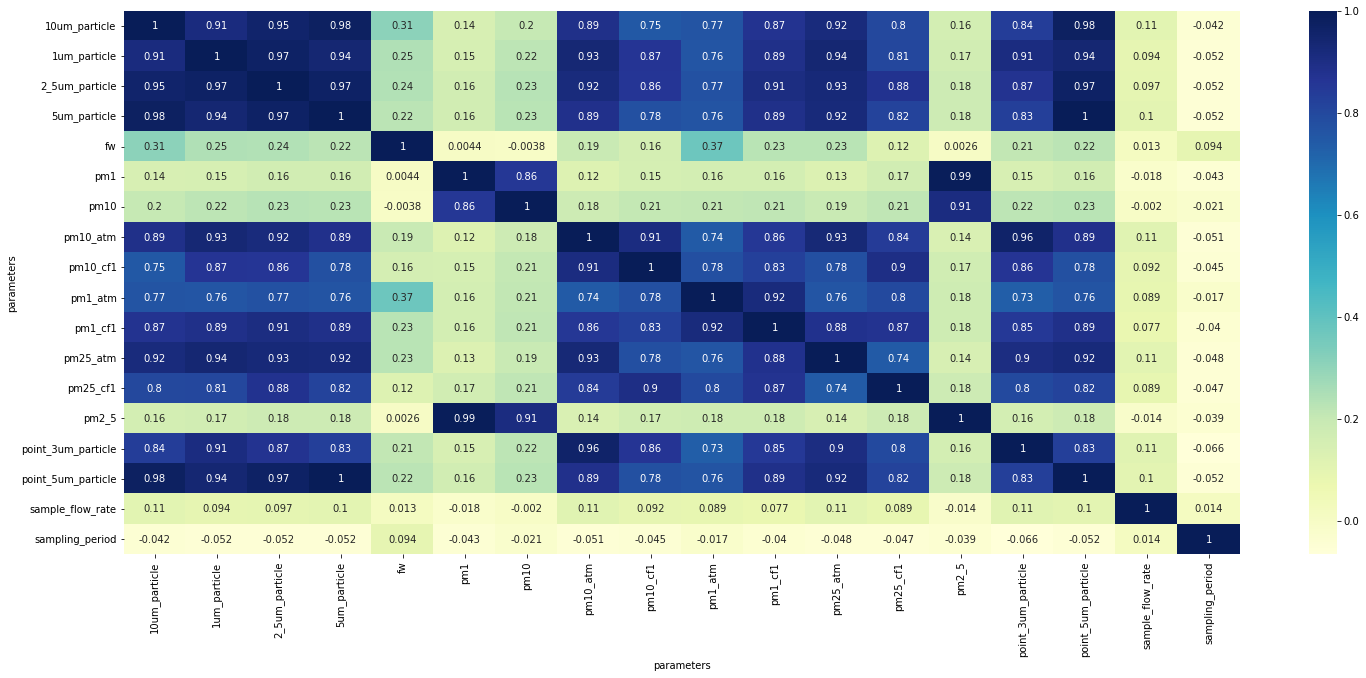

In [43]:
plt.rc('figure', figsize=(25, 10))
sb.heatmap(df_w_pms.corr(method='pearson'), cmap='YlGnBu', annot=True)#.properties(width=800) #cmap='Blues'

# **Causal Inference**

**nodes filtering**

Test with concentration parameter only (i.e. air quality related)

In [44]:
df = filtered_subsystems[filtered_subsystems['parameters'] == 'concentration'].drop(['node_id', 'subsystem', 'parameters'], axis=1)
df

,sensor,date,values
248,co,2018-05-02,7.339609
249,co,2018-05-03,0.476925
250,co,2018-05-04,0.229621
251,co,2018-05-05,0.090416
252,co,2018-05-06,0.092886
...,...,...,...
2807,so2,2019-11-30,0.177827
2808,so2,2019-12-01,0.178804
2809,so2,2019-12-02,0.188689
2810,so2,2019-12-03,0.175606


In [47]:
df = pd.pivot_table(df, values = 'values', index = 'date', columns = 'sensor', aggfunc=np.mean).reset_index()
df = df.fillna(method="bfill")
df

sensor,date,co,h2s,no2,o3,oxidizing_gases,reducing_gases,so2
0,2018-01-17,1.494897,0.003010,1.338691e-03,0.032948,0.174105,0.050681,0.983256
1,2018-01-18,3.901136,0.003010,1.744860e-04,0.028206,0.078152,0.048525,0.908850
2,2018-01-19,3.901136,0.006954,8.506557e-05,0.012484,0.376468,1.533475,2.700144
3,2018-01-20,3.516585,0.010200,7.309485e-05,0.011307,0.195495,1.422494,2.824692
4,2018-01-21,3.417464,0.002880,1.224644e-04,0.008973,0.052806,1.351980,2.862011
...,...,...,...,...,...,...,...,...
1109,2021-02-01,103.236806,2.526280,3.918015e-05,0.038777,20.254887,3.125656,0.257725
1110,2021-02-02,25.361608,3.082614,1.236559e-07,0.000181,24.282013,3.834681,8.802165
1111,2021-02-03,13.810708,6.195348,0.000000e+00,0.003320,26.277093,0.085575,0.181605
1112,2021-02-04,0.073993,0.299267,1.998794e-04,0.101654,3.455060,0.184290,0.561225


In [49]:
df.describe()

sensor,co,h2s,no2,o3,oxidizing_gases,reducing_gases,so2
count,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000
mean,2.451830,0.342337,0.013911,0.059019,1.711597,0.365548,0.588770
std,8.191665,0.702572,0.043895,0.126867,2.746196,0.647289,0.874061
min,0.012310,0.002880,0.000000,0.000000,0.031263,0.016327,0.091207
25%,0.196411,0.025715,0.005967,0.010143,0.225864,0.050959,0.188357
50%,0.373130,0.045807,0.009323,0.020564,0.536136,0.094071,0.245172
75%,0.962708,0.272547,0.014881,0.036994,2.091520,0.361960,0.504534
max,103.236806,6.195348,1.337871,1.373704,32.510403,8.798833,9.130958


In [51]:
# df.columns
df.date = pd.to_datetime(df.date)

base = alt.Chart(df).mark_line().encode(x = 'date:T').properties(width=250, height=250)#.interactive()

chart = alt.vconcat()

row = alt.hconcat()
for gase in ['co:Q', 'h2s:Q', 'no2:Q', 'o3:Q']:
  row |= base.encode(y=gase)
chart &= row

row = alt.hconcat()
for gase in ['oxidizing_gases:Q', 'reducing_gases:Q', 'so2:Q']:
  row |= base.encode(y=gase)
chart &= row

chart

alt.VConcatChart(...)

In [52]:
# wikipedia -> Chicago 1st lockdown: March 21 to Apr 7, then prolonged to Apr 30, then prolonged to May 29 (2020)

training_df = df[df['date'] < '2020-01-01']
training_df

sensor,date,co,h2s,no2,o3,oxidizing_gases,reducing_gases,so2
0,2018-01-17,1.494897,0.003010,0.001339,0.032948,0.174105,0.050681,0.983256
1,2018-01-18,3.901136,0.003010,0.000174,0.028206,0.078152,0.048525,0.908850
2,2018-01-19,3.901136,0.006954,0.000085,0.012484,0.376468,1.533475,2.700144
3,2018-01-20,3.516585,0.010200,0.000073,0.011307,0.195495,1.422494,2.824692
4,2018-01-21,3.417464,0.002880,0.000122,0.008973,0.052806,1.351980,2.862011
...,...,...,...,...,...,...,...,...
707,2019-12-27,0.158612,0.212896,0.005676,0.012725,1.782362,0.140006,0.176011
708,2019-12-28,0.256805,0.243355,0.007135,0.014696,1.063695,0.274369,0.162578
709,2019-12-29,0.421067,0.159214,0.006389,0.034947,1.477506,0.237375,0.316045
710,2019-12-30,0.155591,0.697903,0.005885,0.035904,3.878915,0.078073,0.174607


In [53]:
validation_df = df[(df['date'] >= '2020-01-01') & (df['date'] < '2020-03-21')]
validation_df

sensor,date,co,h2s,no2,o3,oxidizing_gases,reducing_gases,so2
712,2020-01-01,0.140026,0.347868,0.007427,0.128034,0.622743,0.079012,0.240750
713,2020-01-02,2.273081,0.058031,0.012068,0.019973,0.327663,0.066167,0.270215
714,2020-01-03,0.366514,0.404770,0.006984,0.135565,0.657666,0.061782,0.193465
715,2020-01-04,0.166781,0.190331,0.007518,0.069797,0.444112,0.052716,0.172900
716,2020-01-05,0.150449,0.263776,0.006543,0.099526,0.563232,0.056526,0.173843
...,...,...,...,...,...,...,...,...
787,2020-03-16,0.428086,0.033414,0.008226,0.005331,0.544070,0.065633,0.214519
788,2020-03-17,0.345661,0.034863,0.004550,0.007036,0.707976,0.043247,0.131236
789,2020-03-18,0.669432,0.041899,0.004166,0.005757,0.551805,0.098870,0.294495
790,2020-03-19,0.566427,0.051300,0.002523,0.007193,2.446587,0.069386,0.241385


In [54]:
def var_first_diff(df, p, num_forecasts):
    """
    Fits a VAR(p) model on the first-order diff on a df and makes num_forecasts forecasts
    """
    var_res, forecasts = None, None
    
    data = df.diff().dropna()
    var_res = VAR(data).fit(p)
    lag_order = var_res.k_ar

    #forecasts = var_res.forecast(df.values[-lag_order:], steps=num_forecasts)
    forecasts = pd.DataFrame(var_res.forecast(data.values[-lag_order:], steps=num_forecasts), 
                             columns=df.columns, index=[df.index[-1] + pd.DateOffset(i) for i in range(1, num_forecasts+1)])
    
    # print(forecasts.iloc[0])
    forecasts.iloc[0] += df.iloc[-1]
    for i in range(1, num_forecasts):
        forecasts.iloc[i] += forecasts.iloc[i-1]
    
    return var_res, forecasts

In [55]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
param = []
accuracy = []

best_p = 1

best_accuracy = mean_absolute_error(validation_df[['co', 'h2s', 'no2', 'o3', 'oxidizing_gases', 'reducing_gases', 'so2']], 
                     var_first_diff(training_df.set_index('date'), best_p, 80)[1].reset_index().rename(columns={'index':'date'})[['co', 'h2s', 'no2', 'o3', 'oxidizing_gases', 'reducing_gases', 'so2']])

# best_accuracy = mean_squared_error(validation_df[['co', 'h2s', 'no2', 'o3', 'oxidizing_gases', 'reducing_gases', 'so2']], 
#                      var_first_diff(training_df.set_index('date'), best_p, 80)[1].reset_index().rename(columns={'index':'date'})[['co', 'h2s', 'no2', 'o3', 'oxidizing_gases', 'reducing_gases', 'so2']])

for p in range(1, 50):
  param.append(p)
  
  accuracy.append(mean_absolute_error(validation_df[['co', 'h2s', 'no2', 'o3', 'oxidizing_gases', 'reducing_gases', 'so2']], 
                     var_first_diff(training_df.set_index('date'), p, 80)[1].reset_index().rename(columns={'index':'date'})[['co', 'h2s', 'no2', 'o3', 'oxidizing_gases', 'reducing_gases', 'so2']]))
  
  # accuracy.append(mean_squared_error(validation_df[['co', 'h2s', 'no2', 'o3', 'oxidizing_gases', 'reducing_gases', 'so2']], 
  #                    var_first_diff(training_df.set_index('date'), p, 80)[1].reset_index().rename(columns={'index':'date'})[['co', 'h2s', 'no2', 'o3', 'oxidizing_gases', 'reducing_gases', 'so2']]))

  temp_accuracy = accuracy[-1]
  if temp_accuracy <= best_accuracy:
    best_accuracy = temp_accuracy
    best_p = p

print(best_p)

alt.Chart(pd.DataFrame(list(zip(param, accuracy)), columns=['p', 'MAE'])).mark_line().encode(
    x = 'p',
    y = 'MAE'
)

20


alt.Chart(...)

In [56]:
pred_df = var_first_diff(training_df.set_index('date'), 20, 80)[1].reset_index().rename(columns={'index':'date'})
pred_df

sensor,date,co,h2s,no2,o3,oxidizing_gases,reducing_gases,so2
0,2020-01-01,0.735534,0.967160,0.011511,0.086296,3.116311,0.247766,0.506328
1,2020-01-02,1.876128,0.333857,0.016310,0.067483,1.757604,0.078016,0.242790
2,2020-01-03,-0.227686,0.623847,0.007415,0.059688,1.921705,0.147690,0.446760
3,2020-01-04,1.158114,0.898198,0.015618,0.068498,3.283237,0.470856,0.535889
4,2020-01-05,0.900594,0.359083,0.015168,0.010953,1.883589,0.284711,0.292293
...,...,...,...,...,...,...,...,...
75,2020-03-16,0.285671,0.521701,0.009977,0.038651,2.096194,0.118269,0.068674
76,2020-03-17,0.288454,0.516321,0.009974,0.036708,2.093224,0.104421,0.045362
77,2020-03-18,0.288514,0.517905,0.009987,0.040326,2.103195,0.107842,0.054581
78,2020-03-19,0.278527,0.511622,0.009875,0.037491,2.090480,0.100014,0.048434


In [57]:
pred_df = var_first_diff(training_df.set_index('date'), 20, 80)[1].reset_index().rename(columns={'index':'date'})
pred_df


plot_df = validation_df.copy()
plot_df['type'] = 'actual'
pred_df['type'] = 'predictions'
plot_df = plot_df.append(pred_df)

base = alt.Chart(plot_df).mark_line().encode(x = 'date:T', color='type').properties(width=250, height=250)

chart = alt.vconcat()

row = alt.hconcat()
for gase in ['co:Q', 'h2s:Q', 'no2:Q', 'o3:Q']:
  row |= base.encode(y=gase)
chart &= row

row = alt.hconcat()
for gase in ['oxidizing_gases:Q', 'reducing_gases:Q', 'so2:Q']:
  row |= base.encode(y=gase)
chart &= row

chart

alt.VConcatChart(...)

In [58]:
control_df = var_first_diff(df[df['date'] < '2020-03-21'].set_index('date'), 20, 72)[1].reset_index().rename(columns={'index':'date'})
control_df

sensor,date,co,h2s,no2,o3,oxidizing_gases,reducing_gases,so2
0,2020-03-21,9.895412,0.371311,-0.003942,0.068961,3.654375,0.528944,0.589296
1,2020-03-22,12.490642,0.264861,-0.000490,0.165574,3.487264,0.811682,0.915184
2,2020-03-23,1.449356,-0.360456,0.008678,0.025422,0.885160,0.051047,-0.171389
3,2020-03-24,4.251335,0.310532,0.028249,0.090182,1.225354,0.373303,0.532791
4,2020-03-25,2.470887,0.483877,0.036901,0.017211,1.911417,0.421187,-0.115484
...,...,...,...,...,...,...,...,...
67,2020-05-27,7.297213,0.592297,0.012708,0.113134,2.561976,0.460993,0.145491
68,2020-05-28,6.611847,0.634082,0.012205,0.127013,2.821418,0.455191,0.170729
69,2020-05-29,7.473767,0.649702,0.013074,0.122913,2.838684,0.461498,0.175374
70,2020-05-30,7.323788,0.583016,0.013107,0.108548,2.669363,0.425942,0.134405


In [59]:
treatment_df = df[(df['date'] >= '2020-03-21') & (df['date'] < '2020-06-01')]
treatment_df

sensor,date,co,h2s,no2,o3,oxidizing_gases,reducing_gases,so2
792,2020-03-21,0.104436,0.390648,0.006803,0.007724,0.383205,0.225760,0.157867
793,2020-03-22,0.126523,0.176895,0.005110,0.012271,0.298239,0.122899,0.162131
794,2020-03-23,0.157963,1.199130,0.004268,0.025358,3.477446,0.690100,0.186235
795,2020-03-24,0.242807,1.018204,0.005615,0.004690,7.928705,0.583026,0.160169
796,2020-03-25,0.766528,1.136330,0.005076,0.005670,5.152548,0.709856,0.277812
...,...,...,...,...,...,...,...,...
859,2020-05-27,13.912370,0.021303,0.009431,0.019297,0.854800,0.067834,0.178612
860,2020-05-28,13.912370,0.076614,0.006413,0.017294,0.659293,0.067611,0.193474
861,2020-05-29,0.060552,0.028731,0.007033,0.013156,0.472878,0.047954,0.253157
862,2020-05-30,0.087933,0.020844,0.003720,0.007902,0.410647,0.057478,0.181669


In [60]:
causal_df = treatment_df.copy()
causal_df['type'] = 'treatment'
control_df['type'] = 'control'
causal_df = causal_df.append(control_df)

base = alt.Chart(causal_df).mark_line().encode(x = 'date:T', color='type').properties(width=250, height=250)

chart = alt.vconcat()

row = alt.hconcat()
for gase in ['co:Q', 'h2s:Q', 'no2:Q', 'o3:Q']:
  row |= base.encode(y=gase)
chart &= row

row = alt.hconcat()
for gase in ['oxidizing_gases:Q', 'reducing_gases:Q', 'so2:Q']:
  row |= base.encode(y=gase)
chart &= row

chart

alt.VConcatChart(...)

**Confidence Interval**

In [61]:

def var_first_diff_with_CI(df, p, num_forecasts):
    """
    Fits a VAR(p) model on the first-order diff on a df and makes num_forecasts forecasts
    """
    var_res, forecasts = None, None
    
    data = df.diff().dropna()
    var_res = VAR(data).fit(p)
    lag_order = var_res.k_ar

    mean, lower, upper = var_res.forecast_interval(data.values[-lag_order:], steps=num_forecasts)

    # forecasts = pd.DataFrame(var_res.forecast(data.values[-lag_order:], steps=num_forecasts), 
    #               columns=df.columns, index=[df.index[-1] + pd.DateOffset(i) for i in range(1, num_forecasts+1)])


    forecasts_mean = pd.DataFrame(mean, columns=df.columns, index=[df.index[-1] + pd.DateOffset(i) for i in range(1, num_forecasts+1)])
    forecasts_lower = pd.DataFrame(lower, columns=df.columns, index=[df.index[-1] + pd.DateOffset(i) for i in range(1, num_forecasts+1)])
    forecasts_upper = pd.DataFrame(upper, columns=df.columns, index=[df.index[-1] + pd.DateOffset(i) for i in range(1, num_forecasts+1)])

    forecasts_mean.iloc[0] += df.iloc[-1]
    for i in range(1, num_forecasts):
        forecasts_mean.iloc[i] += forecasts_mean.iloc[i-1]
    
    return forecasts_mean, forecasts_lower, forecasts_upper

pred_df_mean, pred_df_lower, pred_df_upper = var_first_diff_with_CI(training_df.set_index('date'), 20, 80)

(sensor            co       h2s  ...  reducing_gases       so2
 2020-01-01  0.735534  0.967160  ...        0.247766  0.506328
 2020-01-02  1.876128  0.333857  ...        0.078016  0.242790
 2020-01-03 -0.227686  0.623847  ...        0.147690  0.446760
 2020-01-04  1.158114  0.898198  ...        0.470856  0.535889
 2020-01-05  0.900594  0.359083  ...        0.284711  0.292293
 ...              ...       ...  ...             ...       ...
 2020-03-16  0.285671  0.521701  ...        0.118269  0.068674
 2020-03-17  0.288454  0.516321  ...        0.104421  0.045362
 2020-03-18  0.288514  0.517905  ...        0.107842  0.054581
 2020-03-19  0.278527  0.511622  ...        0.100014  0.048434
 2020-03-20  0.273860  0.511796  ...        0.101035  0.047508
 
 [80 rows x 7 columns],
 sensor            co       h2s  ...  reducing_gases       so2
 2020-01-01 -4.490375 -1.150059  ...       -0.605417 -0.745395
 2020-01-02 -5.801327 -1.534867  ...       -1.014755 -1.324670
 2020-01-03 -9.073916 -0.6576

In [63]:
# pred_df_mean, pred_df_lower, pred_df_upper

pred_df_CI = pd.merge(validation_df.set_index('date'), pred_df_mean, left_index=True, right_index=True, suffixes=('', '_mean'))
pred_df_CI = pd.merge(pred_df_CI, pred_df_lower, left_index=True, right_index=True, suffixes=('', '_lower'))
pred_df_CI = pd.merge(pred_df_CI, pred_df_upper, left_index=True, right_index=True, suffixes=('', '_upper')).reset_index()
# pred_df_CI

base = alt.Chart(pred_df_CI).mark_line().encode(x = 'date:T').properties(width=250, height=250)

chart = alt.vconcat()

row = alt.hconcat()
for gase in ['co', 'h2s', 'no2', 'o3']:
  # actual = base.mark_line(color='blue').encode(y = alt.Y(gase + ':Q', title=gase))
  predict = base.mark_line(color='orange').encode(y = gase + '_mean:Q')
  ci = base.mark_area(opacity=0.5, color='orange').encode(y = gase + '_lower:Q', y2 = gase + '_upper:Q')
  row |= predict + ci
  # row |= actual + predict + ci
chart &= row

row = alt.hconcat()
for gase in ['oxidizing_gases', 'reducing_gases', 'so2']:
  # actual = base.mark_line(color='blue').encode(y = alt.Y(gase + ':Q', title=gase))
  predict = base.mark_line(color='orange').encode(y = gase + '_mean:Q')
  ci = base.mark_area(opacity=0.5, color='orange').encode(y = gase + '_lower:Q', y2 = gase + '_upper:Q')
  row |= predict + ci
  # row |= actual + predict + ci
chart &= row

chart

alt.VConcatChart(...)